### Imports

In [11]:
import sys
import math
import humanize
import numpy as np
import pandas as pd
from apyori import apriori
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('dark_background')

### Read dataset

In [12]:
f = open("condensed_data.txt", 'r')
data = f.readlines()
f.close()

### Extract data from file and insert it into a 2D array

In [18]:
datalist = []
datalist_item = []

for line in data:
    year = int(line[0:4]) #YEAR

    # PERSONAL INFORMATION

    weight = float(line[391:406]) #WGTPERCY
        # implied 5 decimal places from the right
    age = int(line[160:162]) #V3014
    if year < 2003:
        race = int(line[173:175]) #V2040A
    else:
        race = int(line[175:177]) #V2040B
        # 01 white, 02 black, 03 native, 04 asian
        # AFTER 2003:
        # 05 pacific islander, 06 white-black, 07 white-native, 08 white-asian
        # 09 white-pacific islander, 10 black-native, 11 black-asian, 12 black-pacific islander
        # 13 native-asian, 14 asian-pacific islander, 15 white-black-native, 16 white-black-asian
        # 17 white-native-asian, 18 white-asian-hawaiian, 19 two or three, 20 four or five
        # 98 residue, 99 oou
    sex = int(line[165:166]) #V3018
        # 1 male, 2 female, 8 residue, 9 oou
    sexual_orientation = int(line[336:338]) #V3084
    gender_identity = int(line[340:342]) #V3086
    household_income = int(line[53:55]) #V2026
    urbanicity = int(line[46:48]) #V2143
    reported_to_police = int(line[230:231]) #V3048
    did_not_report = int(line[241:242]) #V3054
    
    # SCREEN QUESTIONS

    victimization_type = int(line[433:434]) #VTYPE
        # 1 violent, 2 property, 3 both
    theft_or_attempted = int(line[200:201]) #V3034
    breakin_or_attempted = int(line[204:206]) #V3036
    motor_vehicle_theft = int(line[209:211]) #V3038
    attacked = int(line[214:215]) #V3040
    # attacked_weapon = int(line[218:219]) #V3042
    # attacked_known = int(line[222:223]) #V3044
    unwanted_sex = int(line[226:227]) #V3046
        # 1 yes, 2 no, 3 refused, 8 residue, 9 oou

    datalist_item.append(year)
    datalist_item.append(weight)

    datalist_item.append(age)
    datalist_item.append(race)
    datalist_item.append(sex)
    datalist_item.append(sexual_orientation)
    datalist_item.append(gender_identity)
    datalist_item.append(household_income)
    datalist_item.append(urbanicity)
    datalist_item.append(reported_to_police)
    datalist_item.append(did_not_report)

    datalist_item.append(victimization_type)
    datalist_item.append(theft_or_attempted)
    datalist_item.append(breakin_or_attempted)
    datalist_item.append(motor_vehicle_theft)
    datalist_item.append(attacked)
    datalist_item.append(unwanted_sex)

    datalist.append(datalist_item)
    datalist_item = []

### Create DataFrame

In [19]:
df = pd.DataFrame(datalist, columns=['year', 'weight', 'age', 'race', 'sex', 
                                     'sexual orientation', 'gender identity', 
                                     'household income', 'urban, suburban, or rural', 
                                     'reported to police', 'did not report to police', 
                                     'victimization type', 'thefts and attempted thefts',
                                     'breakins and attempted breakins', 'motor vehicle thefts', 
                                     'attacks and threats', 'unwanted sexual activity'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016097 entries, 0 to 5016096
Data columns (total 17 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   year                             int64  
 1   weight                           float64
 2   age                              int64  
 3   race                             int64  
 4   sex                              int64  
 5   sexual orientation               int64  
 6   gender identity                  int64  
 7   household income                 int64  
 8   urban, suburban, or rural        int64  
 9   reported to police               int64  
 10  did not report to police         int64  
 11  victimization type               int64  
 12  thefts and attempted thefts      int64  
 13  breakins and attempted breakins  int64  
 14  motor vehicle thefts             int64  
 15  attacks and threats              int64  
 16  unwanted sexual activity         int64  
dtypes: float

#### Sum of all person weights

In [277]:
# weight = approximation of people over 12 in the country represented by each individual surveyed
sum_weights = df['weight'].sum()
# divide by 30 to get rough average of total US population over 12 from 1992-2021
avg_weight = humanize.intcomma(sum_weights / 30)
print(avg_weight)

245,953,377.99231195


### Association mining

In [35]:
f = open("condensed_data.txt", 'r')
data = f.readlines()
f.close()

totalWeight = 0
containsX = 0
containsY = 0
containsBoth = 0

for line in data:
    weight = float(line[391:406]) #WGTPERCY
    # victimization_type = int(line[433:434]) #VTYPE
    theft_or_attempted = int(line[200:201]) #V3034
    attacked = int(line[214:215]) #V3040
    attacked_weapon = int(line[218:219]) #V3042
    attacked_known = int(line[222:223]) #V3044
    # unwanted_sex = int(line[226:227]) #V3046
    # urbanicity = int(line[46:48]) #V2143
    # sex = int(line[165:166]) #V3018
    xToggle = 0
    yToggle = 0

    totalWeight += weight
    if theft_or_attempted == 1: # X
        containsX += weight
        xToggle = 1
    if (attacked == 1) | (attacked_weapon == 1) | (attacked_known == 1): # Y
        containsY += weight
        yToggle = 1
    if (xToggle == 1) & (yToggle == 1): # Both
        containsBoth += weight

# calculates the frequency with which an item appears in the dataset
support = containsBoth / totalWeight

# calculates the strength of association between the X and Y variables
confidence = containsBoth / containsX

# calculates the strength of association between X and Y, taking into 
# account their relative frequency of occurence
# "given X, what is the likelihood of Y?"
# greater than 1 indicates strong association
# 1 indicates no association one way or the other
# less than 1 indicates weak association
lift = confidence / (containsY / totalWeight)

print("X -> victim of a theft or attempted theft")
print("Y -> victim of a violent attack")
print("Support: ", support)
print("Confidence: ", confidence)
print("Lift: ", lift)

X -> victim of a theft or attempted theft
Y -> victim of a violent attack
Support:  0.003261259049524368
Confidence:  0.09287742829384918
Lift:  5.281082917406366


### Linear regression on all violent and property victimization types

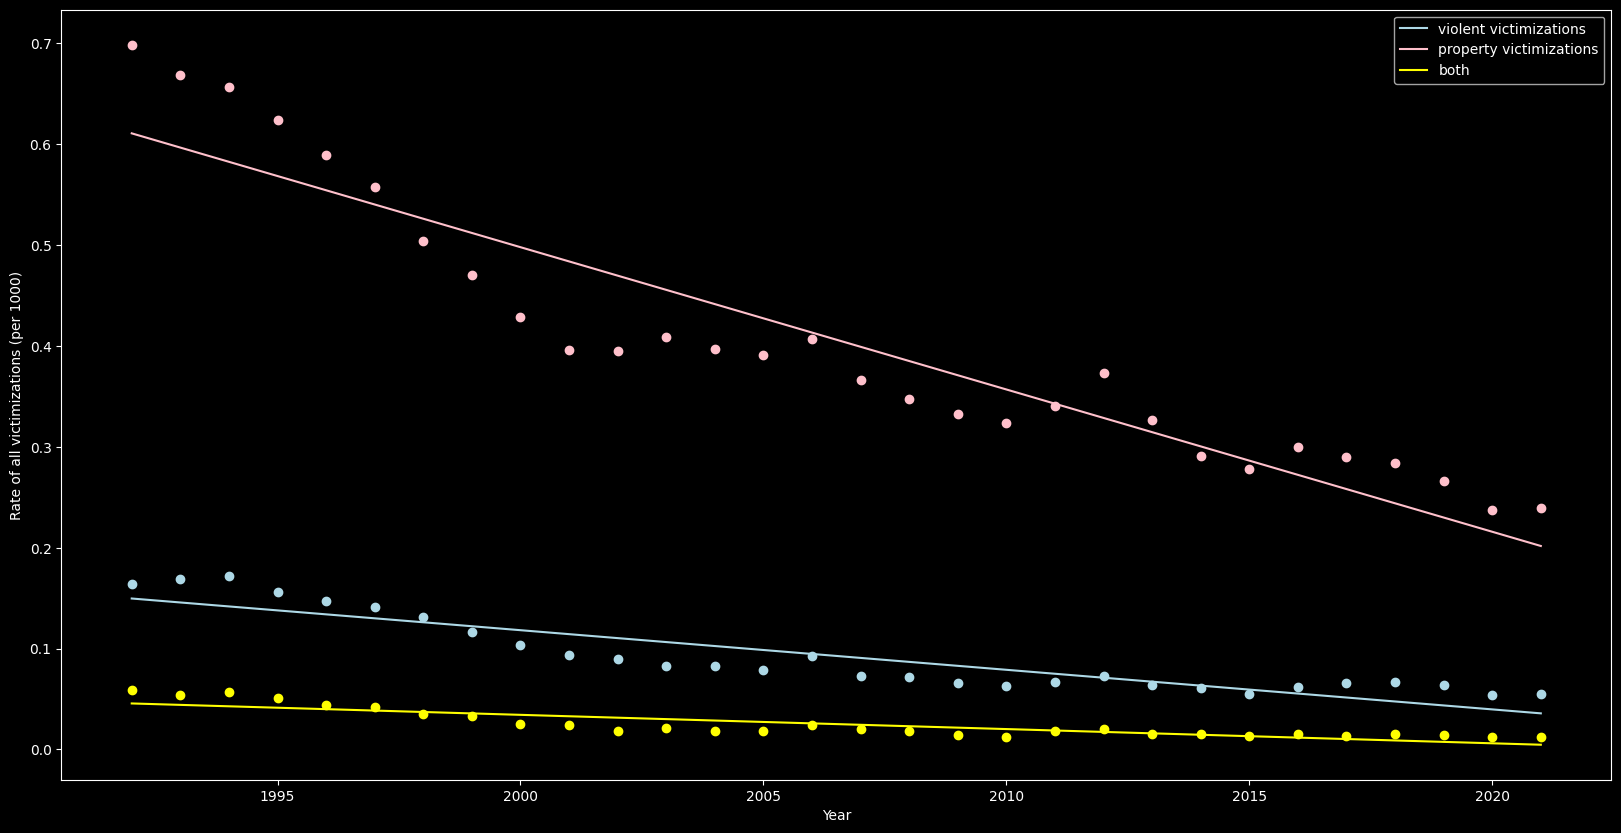

In [21]:
grouped = df.groupby(['year'])['weight'].sum()
totals = grouped.to_list()

# evaluate values divided by total population
def get_rates(values):
    rates = []
    for i in range(0,30):
        if totals[i] == 0:
            rate = 0
        else:
            rate = (values[i] / totals[i]) * 10
        rates.append(rate)
    return rates

# filter for violent victimizations
df_filtered = df[df['victimization type'] == 1]
df1 = df_filtered.groupby(['year', 'victimization type'])['weight'].sum()
vals = df1.to_list()

# linear regression line with numpy
x1 = range(1992,2022)
y1 = get_rates(vals)
regression1 = np.polyfit(x1, y1, deg=1)
trendline1 = np.polyval(regression1, x1)

# filter for property victimizations
df_filtered = df[df['victimization type'] == 2]
df1 = df_filtered.groupby(['year', 'victimization type'])['weight'].sum()
vals = df1.to_list()

# linear regression line with numpy
x2 = range(1992,2022)
y2 = get_rates(vals)
regression2 = np.polyfit(x2, y2, deg=1)
trendline2 = np.polyval(regression2, x2)

# filter for both violent and property victimizations
df_filtered = df[df['victimization type'] == 3]
df1 = df_filtered.groupby(['year', 'victimization type'])['weight'].sum()
vals = df1.to_list()

# linear regression line with numpy
x3 = range(1992,2022)
y3 = get_rates(vals)
regression3 = np.polyfit(x3, y3, deg=1)
trendline3 = np.polyval(regression3, x3)

plt.figure(figsize=(20,10))
plt.scatter(x1, y1, color='lightblue')
plt.scatter(x2, y2, color='pink')
plt.scatter(x3, y3, color='yellow')

plt.plot(x1, trendline1, color='lightblue', label='violent victimizations')
plt.plot(x2, trendline2, color='pink', label="property victimizations")
plt.plot(x3, trendline3, color='yellow', label="both")

plt.xlabel("Year")
plt.ylabel("Rate of all victimizations (per 1000)")
plt.legend()
plt.show()